In [21]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
using LinearAlgebra
using DoubleFloats

In [66]:
# create functionals
μ = 1
ρ = 1
@variables ϵ r x₁ x₂ ;
#r = sqrt(x₁^2 + x₂^2)
#ϕ = exp(-r^2*ϵ^2)
#ϕ = (1.0-r*ϵ)^8 * (32.0*(r*ϵ)^3 + 25.0* (r*ϵ)^2 + 8.0*r*ϵ + 1.0)
ϕ = (1-r*ϵ)^10 * (429*(r*ϵ)^4 + 450*(r*ϵ)^3 + 210*(r*ϵ)^2 + 50*(r*ϵ)+5)
display(ϕ) 
#ϕ = (1-r*ϵ)^4 * (4r*ϵ+1)
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#
ϕ = simplify(ϕ,expand = true)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))

#Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
#∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)) + simplify(expand_derivatives(Differential(r)(exprs)) * (x₁/r)),expand = true)
#∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)) + simplify(expand_derivatives(Differential(r)(exprs)) * (x₂/r)),expand = true)

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0.0; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0.0; 0.0 0.0 ϕ])
#Φ_div = substitute.(Φ_div,r=>sqrt(x₁^2 + x₂^2))

#Φ_div = substitute.([ϕ 0.0 ; 0.0 ϕ],r=>sqrt(x₁^2 + x₂^2))

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]
display(Φ_div)
println("done")

(5 + 50r*ϵ + (210//1)*(r^2)*(ϵ^2) + (429//1)*(r^4)*(ϵ^4) + (450//1)*(r^3)*(ϵ^3))*((1 - r*ϵ)^10)

3×3 Matrix{Num}:
 (130//1)*(ϵ^2) + (12870//1)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^4) + (49920//1)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^11) + (329472//1)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^7) + (366080//1)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^9) + (51480//1)*(x₂^2)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^2) + (549120//1)*(x₂^2)*(ϵ^13)*(sqrt(x₁^2 + x₂^2)^9) + (2306304//1)*(x₂^2)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^5) + (3294720//1)*(x₂^2)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^7) - (3432//1)*(x₂^2)*(ϵ^4) - (1716//1)*(ϵ^4)*(sqrt(x₁^2 + x₂^2)^2) - (6006//1)*(ϵ^14)*(sqrt(x₁^2 + x₂^2)^12) - (120120//1)*(ϵ^8)*(sqrt(x₁^2 + x₂^2)^6) - (450450//1)*(ϵ^10)*(sqrt(x₁^2 + x₂^2)^8) - (180180//1)*(ϵ^12)*(sqrt(x₁^2 + x₂^2)^10) - (720720//1)*(x₂^2)*(ϵ^8)*(sqrt(x₁^2 + x₂^2)^4) - (1801800//1)*(x₂^2)*(ϵ^12)*(sqrt(x₁^2 + x₂^2)^8) - (72072//1)*(x₂^2)*(ϵ^14)*(sqrt(x₁^2 + x₂^2)^10) - (3603600//1)*(x₂^2)*(ϵ^10)*(sqrt(x₁^2 + x₂^2)^6)    …                                                                                                                                                              

done


In [67]:
F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
#display(F_A)
F_A = compile_kernel_array(F_A)
F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
F_B = compile_kernel_array(F_B)

2×6 Matrix{Function}:
 #459  #461  #463  #465  #467  #469
 #471  #473  #475  #477  #479  #481

In [100]:
#= function true_v1(x,y)
    return 20*x*y^3
end
function true_v2(x,y)
    return 5*x^4 - 5*y^4
end
function true_pressure(x,y)
    return 60*x*x*y - 20*y^3 
end =#
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))
#= u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y) =#

u = 20*x*y^3
v = 5*x^4 - 5*y^4
p = 60*x*x*y*y - 20*y^3 

f1 = -dx(dx(u)) - dy(dy(u)) + dx(p)
f2 = -dx(dx(v)) - dy(dy(v)) + dy(p)
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
true_v1 = eval(build_function(u,x,y))
true_v2 = eval(build_function(v,x,y))

120x*(y^2) - 120x*y

120y*(x^2) - 60(x^2)

#549 (generic function with 1 method)

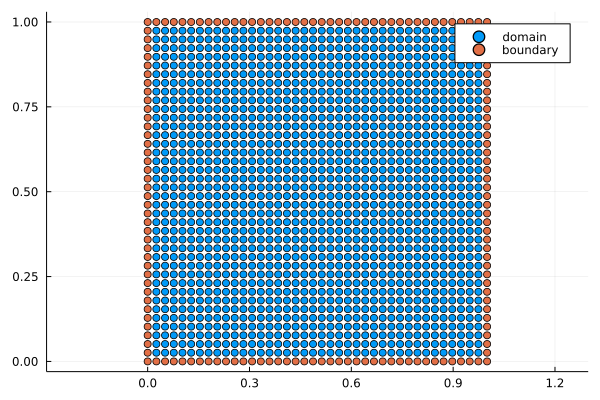

In [104]:
# create points 
N_side = 40
I_points, B_points = generate_2D_equally_spaced_points(N_side)
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
#all_points = [domain_p boundary_p]
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [105]:
# assemble matrices and rhs 

param = 0.1
r = 1.45/(N_side-1)
I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
G = spzeros(2*N_I,2*N_I) # global sprse matrix 
Global_RHS = Float64.(vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:])))#zeros(2*N_I)
#Global_RHS = zeros(2*N_I)
cond_num_array = zeros(N_I)
for i in 1:N_I
    I_idx = inrange(I_tree, I_points[:,i], r, true)
    I_idx = deleteat!(I_idx,findall(x->x==i,I_idx))
    B_idx = inrange(B_tree, I_points[:,i], r, true)
    Full_I_points = hcat(I_points[:,i],I_points[:,I_idx]) # internal points including center 
    default_point_list = [Full_I_points,Full_I_points,I_points[:,I_idx],I_points[:,I_idx]] # list of points if no boundary is present
    sample_point_list = [reshape(I_points[:,i],(2,1)),reshape(I_points[:,i],(2,1))]
    if isempty(B_idx)
        # No boundary points nearby
        #T = point_difference_tensor(Points,Points)
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A[1:4,1:4],T,param))
        B = flatten(generate_block_matrices(F_B[:,1:4],T2,param))
        #RHS = zeros(2*length(I_idx))
        RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
        cond_num_array[i] = cond(A)
        #display(RHS)
    else
        append!(default_point_list,[B_points[:,B_idx],B_points[:,B_idx]])
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A,T,param))
        B = flatten(generate_block_matrices(F_B,T2,param))
        #RHS = vcat(zeros(2*length(I_idx)),true_v1.(B_points[1,B_idx],B_points[2,B_idx]),true_v2.(B_points[1,B_idx],B_points[2,B_idx]))
        RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]),
        true_v1.(B_points[1,B_idx],B_points[2,B_idx]),true_v2.(B_points[1,B_idx],B_points[2,B_idx]))
        cond_num_array[i] = cond(A)
        #display(RHS)
    end
    
    N_I_local = length(I_idx)+1 # total number of local internal points counting the center
    A = Double64.(A)
    C = B*inv(A)
    C = Float64.(C)
    #display(C)
    #println([i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I))
    #display(C[:,1:2*N_I_local])
    G[i,vcat([i],I_idx)] .= C[1,1:N_I_local]
    G[i,vcat([i+N_I],I_idx .+ N_I)] .= C[1,1+N_I_local:2*N_I_local]
    G[i+N_I,vcat([i],I_idx)] .= C[2,1:N_I_local]
    G[i+N_I,vcat([i+N_I],I_idx .+ N_I)] .= C[2,1+N_I_local:2*N_I_local]

    #println(size(C[:,1+2*N_I_local:end]),size(RHS))
    Global_RHS[[i,N_I+i]] .+= -(C[:,1+2*N_I_local:end] * RHS) 
    #display(maximum(abs.(inv(A)*A .- Matrix(I(size(A)[1])))))
    
    
    #println(i,"  ",I_idx)
end
println("max local cond number: ",maximum(cond_num_array))
#println("global condition number: ",cond(Matrix(G)))
#display(G)

max local cond number: 3.786067546623336e16


[8.645130781377176e-6, 6.91610462510174e-5, 0.0002334185310971838, 0.0005532883700081392, 0.0010806413476721467, 0.0018673482487774704, 0.0029652798580123716, 0.004426306960065114, 0.006302300339623964, 0.008645130781377174, 0.011506669070013022, 0.014938785990219763, 0.018993352326685656, 0.023722238864098973, 0.029177316387147975, 0.03541045568052091, 0.042473527528906076, 0.05041840271699171, 0.05929695202946606, 0.06916104625101739, 0.08006255616633402, 0.09205335256010418, 0.10518530621701612, 0.11951028792175811, 0.1350801684590184, 0.15194681861348525, 0.17016210916984698, 0.18977791091279178, 0.210846094627008, 0.2334185310971838, 0.25754709110800744, 0.2832836454441673, 0.3106800648903516, 0.3397882202312486, 0.3706599822515465, 0.4033472217359337, 0.4379018094690981, 0.4743756162357285, 1.729026156275435e-5, 0.0001383220925020348, 0.0004668370621943676, 0.0011065767400162785, 0.0021612826953442935, 0.003734696497554941, 0.005930559716024743, 0.008852613920130228, 0.0126046006

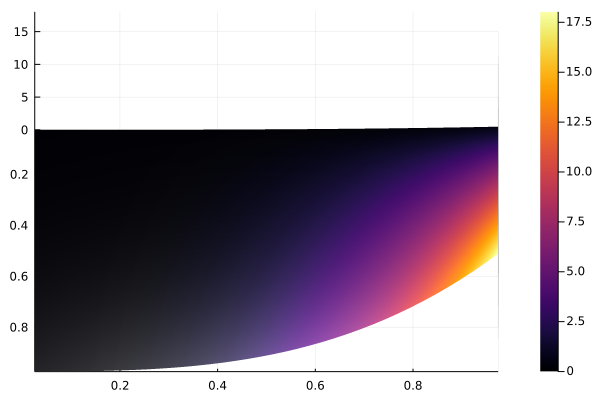

In [106]:
reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

#N_I*2
#cond(Matrix(G))
println(reference_v)
sol = G\Global_RHS
error = abs.(sol - reference_v)
println("max error: ",maximum(error))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I],camera=[90,50])
surface(I_points[1,:],I_points[2,:],sol[1:N_I],camera=[90,70])
#surface(I_points[1,:],I_points[2,:],error[1:N_I])